In [2]:
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

#import warnings
#warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Detect if GPU available, otherwise use CPU

In [3]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


Load MNIST dataset of $28 \times 28$ images. Training does NOT use the test set.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [5]:
def imshow(img):
    '''
    Visualizes IMG.
    IMG should be a 2D torch Tensor.
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(npimg, cmap='gray')
    plt.show()

# Primal Network

This is the definition of the neural classifier for a custom number of layers (depth) and width. The first layer still has $28 \times 28$ features, and the output layer still has ten output classes (0-9).

In [9]:
class Net(nn.Module):
  
  #Constructor with default NN width = 256 and default NN depth = 3
  def __init__(self, width=256, depth=3):
    super().__init__()
    self.layers = nn.ModuleList()
    self.width = width
    self.depth = depth
    for w in range(0, depth - 1):
      if w == 0:
        self.layers.append(nn.Linear(in_features = 28*28, out_features = width))
      elif w == depth - 2:
        self.layers.append(nn.Linear(in_features = width, out_features = 10))   
      else:
        self.layers.append(nn.Linear(in_features = width, out_features = width))
  
  def forward(self, t):
    '''
    On input T, performs a affine transformation, then
    a ReLU, then another affine transformation.
    '''
    self.z = []
    
    t = t.reshape(-1, 28*28)
    for i in range(0, self.depth - 1):
      t = self.layers[i](t)
      self.z.append(t)
      if i != self.depth - 2:
        t = F.relu(t)
    return t


Provided training code using Adam.

In [10]:
def train(net, criterion, trainloader, lr=0.001):
    '''
    Uses the Adam optimization algorithm to train 
    the classifier NET on training data from TRAINLOADER,
    on loss function CRITERION, with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(3):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())

Train the network using cross entropy loss. Note that this is equivalent to maximizing the KL-divergence.

In [11]:
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()

train(net, criterion, trainloader, 0.001)

Epoch 0 Iter: 0 Loss 2.3855669498443604
Epoch 0 Iter: 500 Loss 1.2561038732528687
Epoch 0 Iter: 1000 Loss 0.11339790374040604
Epoch 0 Iter: 1500 Loss 0.5455701947212219
Epoch 0 Iter: 2000 Loss 0.02579677477478981
Epoch 0 Iter: 2500 Loss 0.9998983144760132
Epoch 0 Iter: 3000 Loss 0.40128687024116516
Epoch 0 Iter: 3500 Loss 0.045285217463970184
Epoch 0 Iter: 4000 Loss 0.15852096676826477
Epoch 0 Iter: 4500 Loss 0.1748335063457489
Epoch 0 Iter: 5000 Loss 0.12577465176582336
Epoch 0 Iter: 5500 Loss 0.08513245731592178
Epoch 0 Iter: 6000 Loss 0.1739739030599594
Epoch 0 Iter: 6500 Loss 0.03151215985417366
Epoch 0 Iter: 7000 Loss 0.01883954182267189
Epoch 0 Iter: 7500 Loss 0.022863224148750305
Epoch 0 Iter: 8000 Loss 0.005430187564343214
Epoch 0 Iter: 8500 Loss 0.0013404235942289233
Epoch 0 Iter: 9000 Loss 0.0926351547241211
Epoch 0 Iter: 9500 Loss 0.018720833584666252
Epoch 0 Iter: 10000 Loss 0.08377524465322495
Epoch 0 Iter: 10500 Loss 0.41179296374320984
Epoch 0 Iter: 11000 Loss 0.11705738

In [12]:
test_iter = iter(testloader)

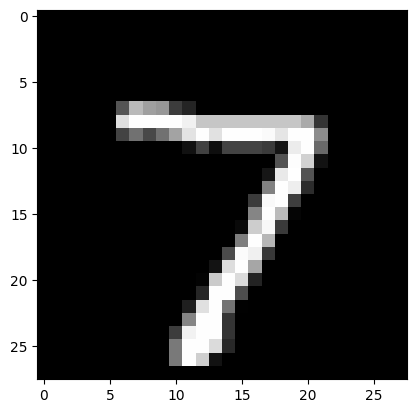

Classifier output: tensor([[ -9.4023, -14.9840,  -1.9853,  -2.1988, -20.5725, -10.6118, -28.1723,
           7.1632,  -8.9985,  -4.0987]])
Classifier prediction: 7


In [13]:
x, labels = next(test_iter)
x = x[0].unsqueeze(0)
labels = labels[0].unsqueeze(0)
imshow(x[0,0])

x = x.to(device)
labels = labels.to(device)

out = net(x).data
print('Classifier output:', out)
print('Classifier prediction:', torch.argmax(out).item())

Let's look at accuracy now.

In [14]:
def accuracy(net, testloader):
    '''
    Returns the accuracy of classifier NET
    on test data from TESTLOADER.
    '''
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [15]:
print('Classifier accuracy on original test dataset:', accuracy(net, testloader))

Classifier accuracy on original test dataset: 0.972


Implement FGSM Method:

In [16]:
def FGSM(x, labels, net, eps):
    '''
    Given an input image X and its corresponding labels
    LABELS, as well as a classifier NET, returns X
    perturbed by EPS using the fast gradient sign method.
    '''
    net.zero_grad()    # Zero out any gradients from before
    x.requires_grad=True    # Keep track of gradients
    out = net(x)    # Output of classifier
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, labels)   # Classifier's loss
    loss.backward()
    grads = x.grad.data    # Gradient of loss w/r/t input
    return x + eps*torch.sign(grads)

Now we define an epsilon value for FGSM perturbation:

In [17]:
eps = 0.05

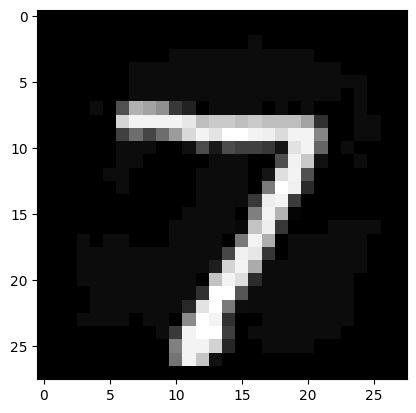

Classifier output: tensor([[ -7.9862, -12.8659,  -0.3887,  -0.5868, -20.5802,  -9.2470, -25.0677,
           5.4034,  -6.7708,  -4.9613]])
Classifier prediction: 7


In [18]:
# We are using the same sample input x as before.
x.requires_grad = True
x_prime = FGSM(x, labels, net, eps)
imshow(x_prime[0,0].cpu())
out = net(x_prime)

print('Classifier output:', out.data)
print('Classifier prediction:', torch.argmax(out).item())

From original assignment:
We should evaluate the classifier's performance on FGSM-perturbed data by the same metric that we will later use in the primal adversarial problem. That is, for the classifier's output vector $\vec{\hat{z}}_3$, we want to compute
$$
\vec{c}_j^\top \vec{\hat{z}}_3
$$
where
$$\vec{c}_j={\vec{y}_{\text{true}}}-\vec{e}_{j}$$
for each $j\in[10]$.

Recall that 
$$\vec{c}_j^\top \vec{\hat{z}}_3=\vec{\hat{z}}_{3i_{\text{true}}}-\vec{\hat{z}}_{3j},$$
i.e. $\vec{c}_j^\top \vec{\hat{z}}_3$ is the difference between the classifier's confidence on the true class and the $j$th (incorrect) class. If $\vec{c}_j^\top \vec{\hat{z}}_3$ is positive for all incorrect $j$, then the classifier was not fooled by the adversarial perturbation.

In [19]:
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, (out @ c).item())

0 13.389642715454102
1 18.26932144165039
2 5.792145252227783
3 5.990193843841553
4 25.983566284179688
5 14.650418281555176
6 30.4710693359375
8 12.17419147491455
9 10.364696502685547


In [60]:
def accuracy_on_FGSM(net, testloader, eps):
    '''
    Returns the accuracy of classifier NET on test
    data from TESTLOADER that has been perturbed by
    EPS using FSGM.
    '''
    correct = 0
    total = 0
    for data in testloader:
        x, labels = data[0].to(device), data[1].to(device)
        x_prime = FGSM(x, labels, net, eps)
        outputs = net(x_prime)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total

In [61]:
print('Classifier accuracy on test dataset perturbed with FGSM:', accuracy_on_FGSM(net, testloader, eps))

Classifier accuracy on test dataset perturbed with FGSM: 0.8918


# Dual Network

From original assignment: $\newline$
Here, we will implement the dual network. First, we write the function to compute upper and lower bounds for the dual network. This function should take an input image, the trained classifier, and an epsilon value, and return the tuple
$$(\vec{l},\vec{u},S,S^-,S^+)$$
where $\vec{u}$ and $\vec{l}$ are the upper and lower bounds, respectively, for the input to the ReLU layer, and $S^-,S^+,S$ are sets defined by

$$
\begin{aligned}
&S:=\{j\in [n_2]\mid l_{j}\leq 0\leq u_{j}\}\\
&S^{-}:=\{j\in [n_2]\mid l_{j}\leq u_{j}\leq 0\}\\
&S^{+}:=\{j\in [n_2]\mid 0\leq l_{j}\leq u_{j}\}.
\end{aligned}
$$

See Section 6 of the PDF for more details.

In [175]:
def dual_bounds(x, net, eps):
    '''
    Given a classifier NET, an input image X,
    and the epsilon parameter EPS, returns the lower
    and upper bounds L and U respectively, as well as
    the corresponding sets S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)    # Reshape input to more convenient dimensions
    W = [layer.weight for layer in net.layers]    # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]    # Array of network biases (b vectors)
    n = W[1].shape[1]    # Dimensionality of hidden layer

    U = []
    L = []
    S = []
    S_plus = []
    S_min = []

    for j in range(0, net.depth - 2):
        u = torch.Tensor([W[j][i] @ x + b[j][i] + eps * torch.norm(W[j][i], 1) for i in range(0, n)])
        l = torch.Tensor([W[j][i] @ x + b[j][i] - eps * torch.norm(W[j][i], 1) for i in range(0, n)])
        U.append(u)
        L.append(l)

        s = [i for i in range(0, n) if l[i] <= 0 and u[i] >= 0]
        s_plus = [i for i in range(0, n) if l[i] <= u[i] and l[i] >= 0]
        s_min = [i for i in range(0, n) if u[i] <= 0 and u[i] >= l[i]]
        S.append(s)
        S_plus.append(s_plus)
        S_min.append(s_min)

    return U, L, S, S_min, S_plus

From original assignment: $\newline$
Given the tuple $(l,u,S,S^-,S^+)$, we are ready to calculate the dual objective itself. This function should take in an input image, the classifier, a vector $c$, and the $(l,u,S,S^-,S^+)$ from the previous function in order to output 
$$
d^*(\vec{x},\vec{c})= 
-\vec{\hat{\nu}}_1^\top \vec{x}-\varepsilon\|\vec{\hat{\nu}}_1\|_1-\sum_{i=1}^{2}\vec{\nu}_{i+1}^\top \vec{b}_i+\sum_{j\in S\
}l_{j}\text{ReLU}(\nu_{2j})
$$

Where the $\vec{\nu}$ vectors are computed as
$$
\begin{aligned}
&\vec{\nu}_3=-\vec{c}\\
&\vec{\hat{\nu}}_2=W_2^\top \vec{\nu}_{3}\\
&\nu_{2j}=0 && \forall j\in S^-\\
&\nu_{2j}=\hat{\nu}_{2j} && \forall j\in S^+\\
&\nu_{2j}=\dfrac{u_{j}}{u_{j}-l_{j}}\hat{\nu}_{2j} && \forall j\in S\\
&\vec{\hat{\nu}}_1=W_1^\top \vec{\nu_{2}}
&\end{aligned}.
$$

Again, see Section 6 of the PDF for more details.

One efficient way to compute $\vec{\nu}_2$ is to rewrite it as
$$\vec{\nu}_2= D\vec{\hat{\nu}}_2,$$
where $D$ is a diagonal matrix defined  by
$$
D_{jj}=\begin{cases}
0 & j\in S^-\\
\hat{\nu}_{2j} & j\in S^+\\
\dfrac{u_{j}}{u_{j}-l_{j}}\hat{\nu}_{2j} & j\in S.
\end{cases}
$$

In [221]:
# Constructs the diagonal D matrix from the S sets, n (the dimensionality
# of the hidden layer), u, and l.
def StoD(S_min, S_plus, S, n, U, L):
    '''
    Given upper and lower bounds U and L, as well
    as the corresponding sets S_MIN, S_PLUS, and S,
    as well as the dimension of the hidden layer N,
    returns the corresponding diagonal matrix D.
    '''
    D = []
    for i in range(0, net.depth - 2):
        d = []
        for j in range(n):
            if j in S[i]:
                d.append((U[i][j] / (U[i][j] - L[i][j])).item())
            elif j in S_plus[i]:
                d.append(1)
            elif j in S_min[i]:
                d.append(0)
            else:
                assert False, 'StoD error.'
        D.append(torch.diag(torch.Tensor(d)).to(device))
    return D

def dual_forward(x, net, c, eps, L, U, S, S_min, S_plus):
    '''
    Calculates the dual objective for classifier NET with input X
    and dual input C and epsilon parameter S. Depends on lower
    and upper bounds L and U, as well as the corresponding sets
    S, S_MIN, S_PLUS.
    '''
    x = x[0].reshape(-1, 1)    # Reshape input to more convenient dimensions
    W = [layer.weight for layer in net.layers]    # Array of network weights (W matrices)
    b = [layer.bias.reshape(-1, 1) for layer in net.layers]    # Array of network biases (b vectors)
    n = W[1].shape[1]    # Dimensionality of hidden layer
    D = StoD(S_min, S_plus, S, n, U, L)

    nu = []
    nuh = []
    for i in range(0, net.depth - 1):
        if i == 0:
            nu.append(-c)
        else:
            nu.append(D[net.depth - 2 - i] @ nuh[i - 1])
        nuh.append(W[net.depth - 2 - i].T @ nu[i])
    
    nuh = nuh[::-1]
    nu = nu[::-1]
    
    nu_sum = 0
    for i in range(1, net.depth - 1):
        nu_sum += nu[i].T @ b[i]
    
    relu_sum = 0
    for i in range(0, net.depth - 2):
        for j in range(len(nu[i])):
            if j in S[i]:
                relu_sum += L[i][j] * torch.relu(nu[i][j])

    dual = -1 * (nuh[0].T @ x) - eps * (torch.norm(nuh[0], 1)) - nu_sum + relu_sum

    return dual

In [233]:
eps = 0.05

In [234]:
# We are still using the same sample input x as before.
L, U, S, S_min, S_plus = dual_bounds(x, net, eps)

# print(l, u, S, S_min, S_plus)
# Here, we loop through each column c_j defined above, and output the 
# objective value for the dual function with input c.
for i in range(10):
    c = torch.zeros(10, 1).to(device)
    if i != labels:
        c[i] = -1
        c[labels] = 1
        print(i, dual_forward(x, net, c, eps, L, U, S, S_min, S_plus).item())

0 8.477635383605957
1 14.899110794067383
2 6.9059977531433105
3 6.173763275146484
4 21.04520606994629
5 12.364008903503418
6 30.433231353759766
8 6.338945388793945
9 0.8904035091400146


In [172]:
def robust_loss(x, label, net, eps, criterion):
    '''
    Given a batch of input images X, its corresponding lables LABEL,
    the classifier NET, epsilon value EPS, and original loss
    function CRITERION, returns the robust loss of NET w/r/t
    the original loss function, on the input image.
    '''
    l, u, S, S_min, S_plus = dual_bounds(x, net, eps)
    # We assume there are 10 classes.
    e_y = torch.zeros(10, 1)
    e_y[label] = 1
    c = e_y @ torch.ones(1, 10) - torch.eye(10)
    J = dual_forward(x, net, c, eps, l, u, S, S_min, S_plus).unsqueeze(0)
    return criterion(-J, label.unsqueeze(0))

In [173]:
def robust_train(net, criterion, trainloader, eps, lr=0.001):
    '''
    Trains the classifier NET using the robust version
    of the original loss function CRITERION with paramater EPS,
    using training data from TRAINLOADER and with learning rate LR.
    
    Note that we half the learning rate each epoch.
    '''
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(3):
        for i, data in enumerate(trainloader, 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.5 ** (epoch)

            inputs, labels = data
            optimizer.zero_grad()
            loss = 0
            for i in range(inputs.shape[0]):
                x = inputs[i].unsqueeze(0)
                label = labels[i].unsqueeze(0)
                loss += robust_loss(x, label, net, eps, criterion)
            loss.backward()
            optimizer.step()
    
            if i % 500 == 0:
                print('Epoch', epoch, 'Iter:', i, 'Loss', loss.item())